In [387]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (8, 8)
legend_fontsize = 16

from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

In [388]:
from matplotlib.dates import DateFormatter

In [389]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (8, 8)


## `Часть I: О теореме Байеса`

`Задание 1`

`Задание 2`

`Задание 3`

В задании сказано что можем уменьшить один тип ошибок - false positives (когда тест выдаёт положительный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного).

В confusion matrix (матрица ошибок) это ячейки FP или FN

Уменьшая FP будут вырастать TP и TN так как сумма протестированных людей должна остаться неизменной (сумма по строке) и количество здоровых (сумма по столбцу).

То есть TP + FP = 1 (это понадобится для первого графика), .. + .. = 1 (это для второго графика)

При этом изменения FP **никак** не скажутся на ячейке FN. Значит "уловок" в задании нет, FP и FN независимы друг от друга, так что можно честно нарисовать 2 графика: P( d | t ) и P( d | не-t )


In [390]:
def compute_posterior_mod(data, prior_prob=0.01, test_success_pos=0.95, test_success_neg=0.95):
    """ Eсли data = 1, тест положительный
        test_success_pos = P ( t | d) = вероятность true positive 
        test_success_neg = P ( не-t | не-d) = вероятность true negative 
    """
    if data == 1:
        return (prior_prob * test_success_pos) / (prior_prob * test_success_pos + (1 - prior_prob) * (1 - test_success_pos))
    elif data == 0:
        return (prior_prob * (1-test_success_neg)) / (prior_prob * (1-test_success_neg) + (1-prior_prob) * test_success_neg)
    else:
        return None

print("Апостериорная вероятность после положительного теста: %.6f" % compute_posterior_mod(1) )
print("Апостериорная вероятность после отрицательного теста: %.6f" % compute_posterior_mod(0) )

Апостериорная вероятность после положительного теста: 0.161017
Апостериорная вероятность после отрицательного теста: 0.000531


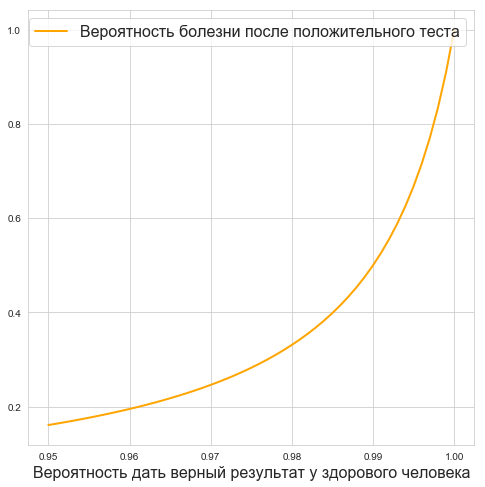

In [391]:
vector_posterior = np.vectorize(compute_posterior_mod, excluded=['data', 'prior_prob'])

xs = np.arange(0.95, 1, 0.001)
ys_one = vector_posterior(1, test_success_pos=xs)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(xs, ys_one, linewidth=2, label=r'Вероятность болезни после положительного теста', color='orange')
# ax.plot(xs, ys_zero, linewidth=2, label='Вероятность после отрицательного теста')
# ax.set_xlim((0.0, 0.3))
ax.set_xlabel('Вероятность дать верный результат у здорового человека', fontsize=legend_fontsize)
ax.legend(fontsize=legend_fontsize)
# fig.savefig('intro1.pdf', bbox_inches='tight')
plt.show()

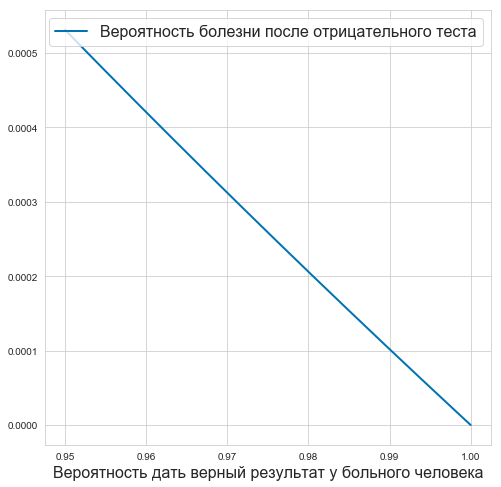

In [392]:
vector_posterior = np.vectorize(compute_posterior_mod, excluded=['data', 'prior_prob'])

xs = np.arange(0.95, 1, 0.0001)
ys_one = vector_posterior(1, test_success_neg=xs)
ys_zero = vector_posterior(0, test_success_neg=xs)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
# ax.plot(xs, ys_one, linewidth=2, label=r'Вероятность после положительного теста')
ax.plot(xs, ys_zero, linewidth=2, label='Вероятность болезни после отрицательного теста')
# ax.set_xlim((0.0, 0.3))
ax.set_xlabel('Вероятность дать верный результат у больного человека', fontsize=legend_fontsize)
ax.legend(fontsize=legend_fontsize)
# fig.savefig('intro1.pdf', bbox_inches='tight')
plt.show()

Комментарий: по первому графику видно как медленно растет вероятность болезни, если мы будем бороться с ошибками FP (когда здоровому говорим что он болен). Если же сосредоточить усилия на уменьшение FN (когда больному говорим, что он здоров) то видим, что резко снижается вероятность ошибки - производная где-то равна минус 5 - то есть небольшое увеличение по оси X дает пятикратное снижение по оси Y

Получается мы либо слишком "пугаем" здоровых людей, либо "успокаиваем" тех, кому нужна помощь. Без понимания что это за болезнь, сложно дать какие-то рекомендации. Возможно у нас переполнены больницы, и по 2 раза сдавать тест на заболевание никак нельзя. А может быть так, что если слишком успокаивать действительно больных (False negative) то мы сильно увеличим смертность среди таких людей

## `Часть II: О линейной регрессии`

In [393]:
# https://ourworldindata.org/coronavirus-source-data
df = pd.read_csv('./owid-covid-data.csv')

In [394]:
df = df[(df.iso_code == 'RUS') & (df.date > '2020-03-03')][['date', 'total_cases', 'new_cases']]

In [395]:
df['day'] = df.reset_index().index + 1

In [396]:
train = df[:50].copy()
test = df[50:120].copy()

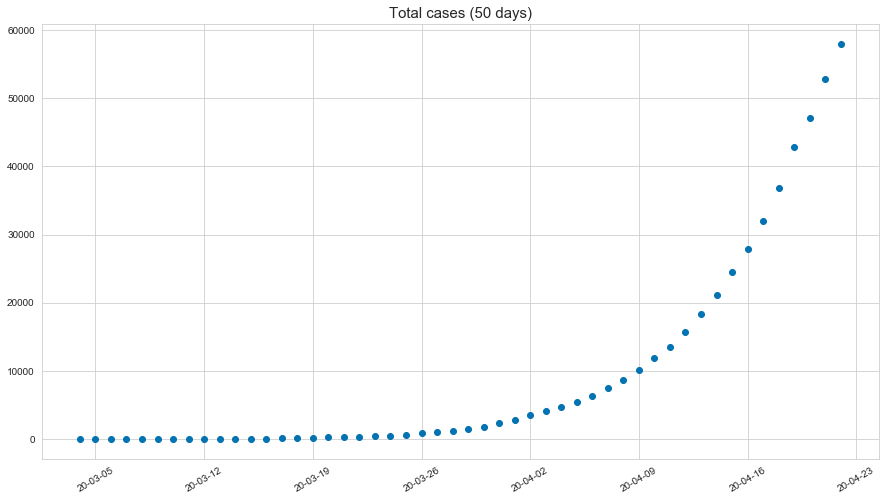

In [397]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot_date(pd.to_datetime(train.date), train.total_cases)
plt.title('Total cases (50 days)', size=15)

formatter = DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

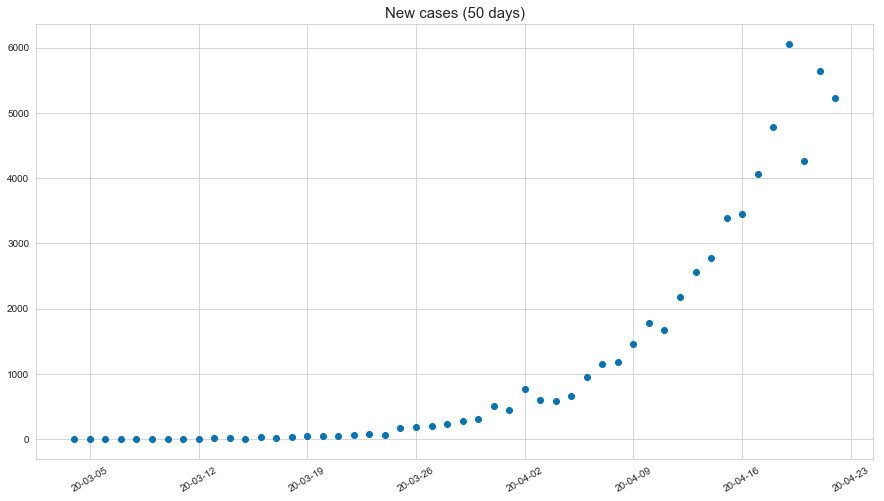

In [398]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot_date(pd.to_datetime(train.date), train.new_cases)
plt.title('New cases (50 days)', size=15)

formatter = DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

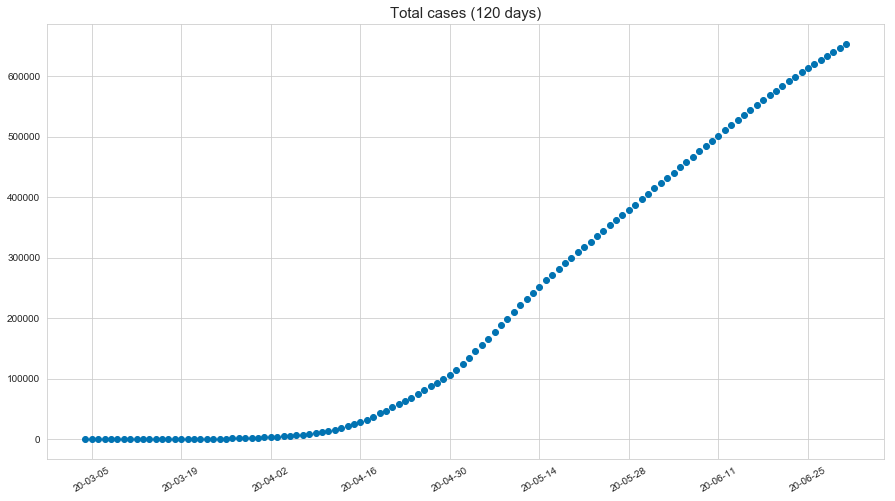

In [399]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot_date(pd.to_datetime(df.date[:120]), df.total_cases[:120])
plt.title('Total cases (120 days)', size=15)

formatter = DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

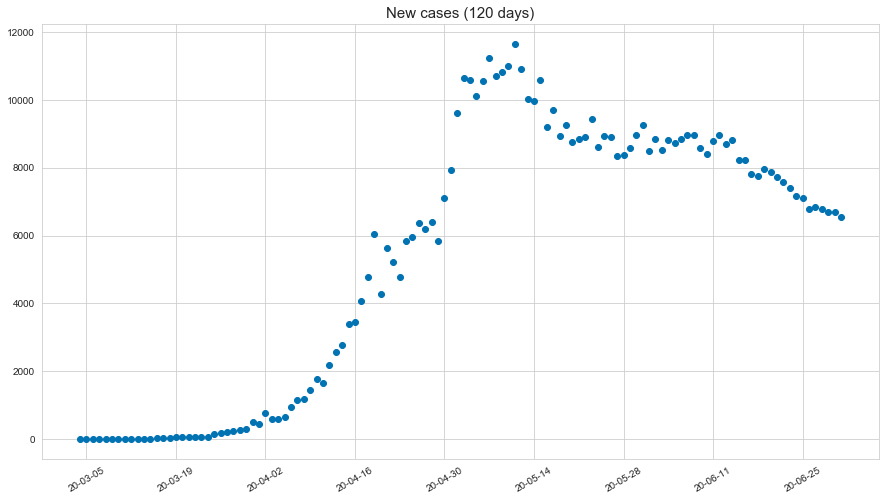

In [400]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot_date(pd.to_datetime(df.date[:120]), df.new_cases[:120])
plt.title('New cases (120 days)', size=15)

formatter = DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

`Обучим модель вида y = exp( kx + b ) с помощью градиентного спуска (sklearn.linear_model)`

In [401]:
from sklearn.linear_model import LinearRegression

In [402]:
train['log_total_cases'] = np.log(train.total_cases)

In [403]:
lr = LinearRegression(fit_intercept=True)
lr.fit(train[['day', ]] , train.log_total_cases)
print('Параметры линейной модели при обучении градиентным спуском:')
print(f'w0: {lr.intercept_}, wi: {lr.coef_}')

test_preds = np.expm1(lr.predict(test[['day', ]]))
train_preds = np.expm1(lr.predict(train[['day', ]]))

Параметры линейной модели при обучении градиентным спуском:
w0: 1.9109596753423403, wi: [0.1947175]


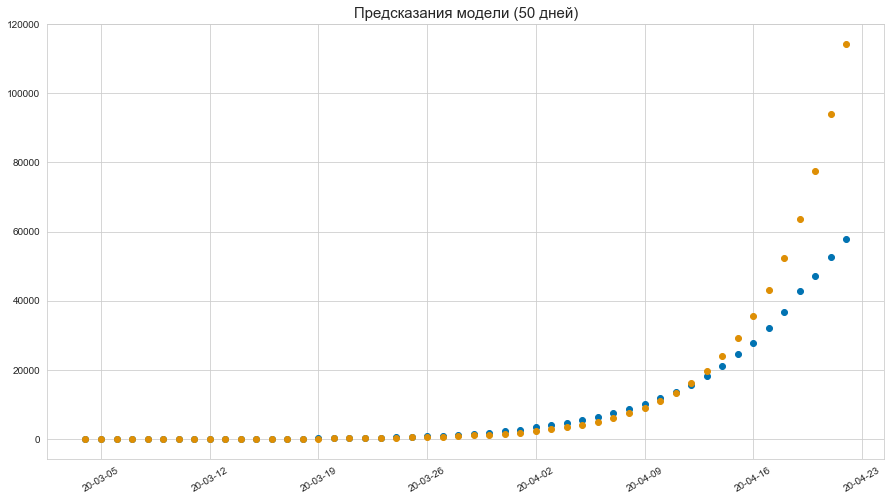

In [404]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot_date(pd.to_datetime(df.date[:50]), df.total_cases[:50])
plt.plot_date(pd.to_datetime(df.date[:50]), train_preds)
plt.title('Предсказания модели (50 дней)', size=15)

formatter = DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

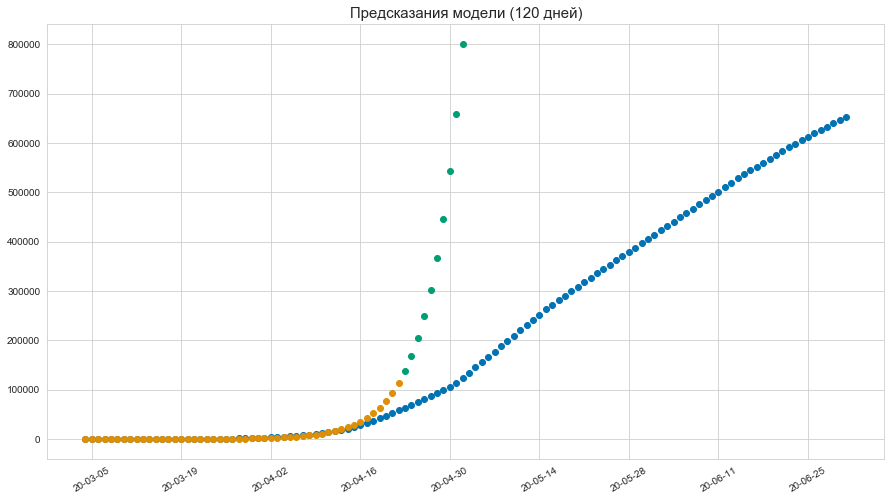

In [405]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot_date(pd.to_datetime(df.date[:120]), df.total_cases[:120])
plt.plot_date(pd.to_datetime(df.date[:50]), train_preds)
plt.plot_date(pd.to_datetime(df.date[50:60]), test_preds[:10])
plt.title('Предсказания модели (120 дней)', size=15)

formatter = DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

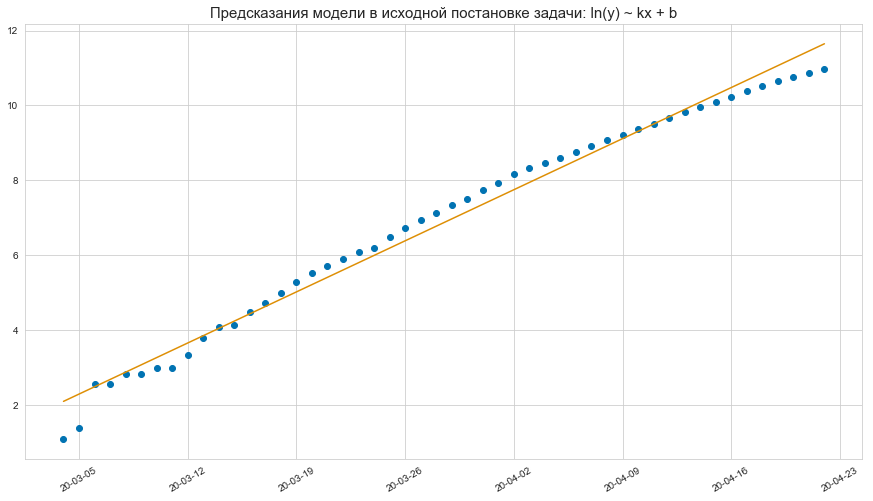

In [406]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot_date(pd.to_datetime(train.date), train.log_total_cases)
plt.plot(pd.to_datetime(train.date), lr.predict(train[['day', ]]))
plt.title('Предсказания модели в исходной постановке задачи: ln(y) ~ kx + b', size=15)

formatter = DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

`Теперь попробуем получить параметры модели с помощью байесовского вывода`

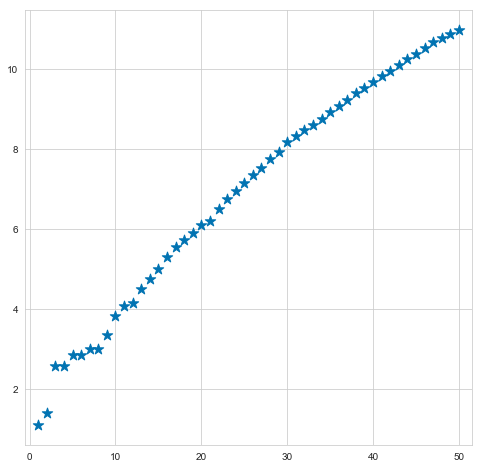

In [407]:
## Исходная функция
N = 250

## X-координаты точек данных
xd = train.day.values
num_points = len(xd)

## Данные
data = train.log_total_cases.values

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.scatter(xd, data, marker='*', s=120)
plt.show()

In [409]:
xss = np.linspace(-3, 3, N)
X = np.linspace(0, 2, N)
Y = np.linspace(0, 2, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)

(250, 250)


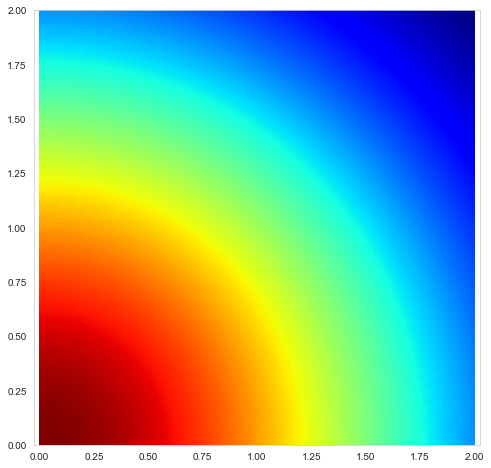

In [410]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
myplot_heatmap(Z)

In [411]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

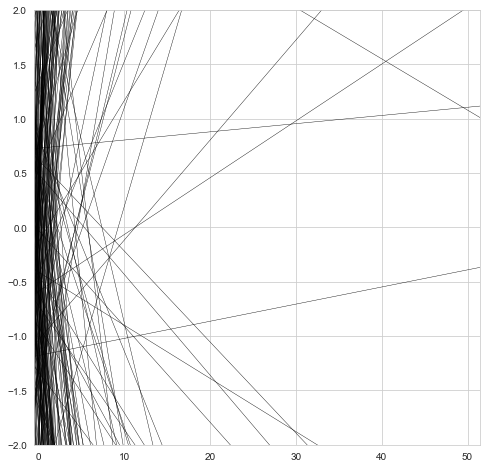

In [412]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, 200)

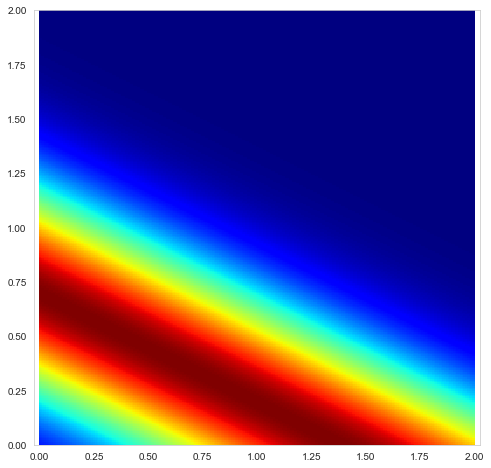

In [413]:
def get_likelihood(px, py, sigma=.5):
    """ Функция правдоподобия в одной точке """
    return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

px, py = xd[1], data[1]
cur_likelihood = get_likelihood(px, py)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
myplot_heatmap(Z)

In [414]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

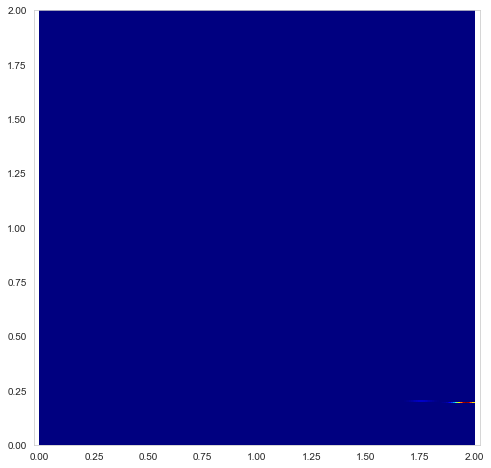

In [416]:
from IPython.display import clear_output

# инициализация из достаточно широкого нормального распределения
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[33, 0], [0, 33]])

for i in range(len(xd)):
# for i in [0, 1, 3, 5, 15, 17, 19, 25, 27, 28, 29, 30, 40, 41 ,42, 49]:
# for i in [0, 1, 3]:
    
    px, py = xd[i], data[i]
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
    
    Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    myplot_heatmap(Z)
    plt.show()
    
    clear_output(True)


`Байесовский вывод приходит к параметрам линейной регрессии из sklearn, где w0, w1 были равны (1.91, 0.1947)`

In [417]:
points = (train.day.values, train.log_total_cases.values)

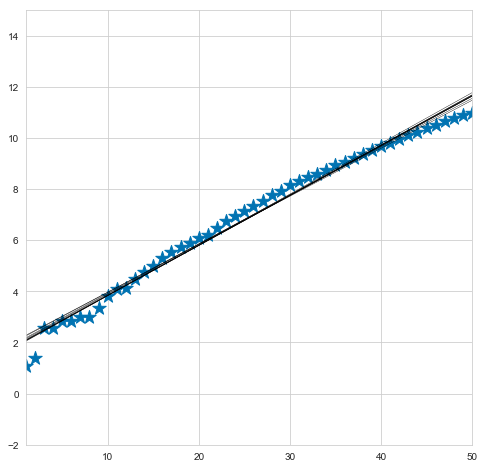

In [418]:
#### Посэмплируем и порисуем прямые
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((1, 50))
ax.set_ylim((-2, 15))
myplot_sample_lines(cur_mu, cur_sigma, 10, points=points)

In [419]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [420]:
# Нарисуем результат
def plot_predictions(xs, mu, x, points, sigma_noise):
    """ Заменил 0.25 на sigma_noise """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 15))
#     ax.plot(xs, true_curve(xs), label="Правильный ответ")
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - sigma_noise, mu[1]*xs + mu[0] + sigma_noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

In [421]:
# значение дисперсии шума оценим исходя из обученной линейной модели с параметрами w0: 1.91, wi: [0.1947]
sigma_noise = np.std(train.log_total_cases.values - lr.predict(train[['day']]))

In [422]:
sigma_noise

0.347145592611712

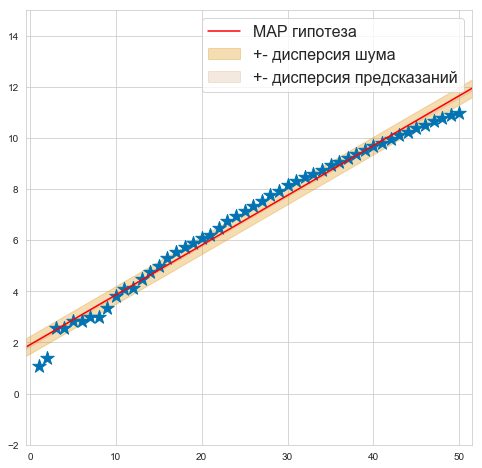

In [424]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=100)
plot_predictions(xs, cur_mu, x, points, sigma_noise)

`Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).`


In [425]:
my_w = np.random.multivariate_normal(cur_mu, cur_sigma, 1)

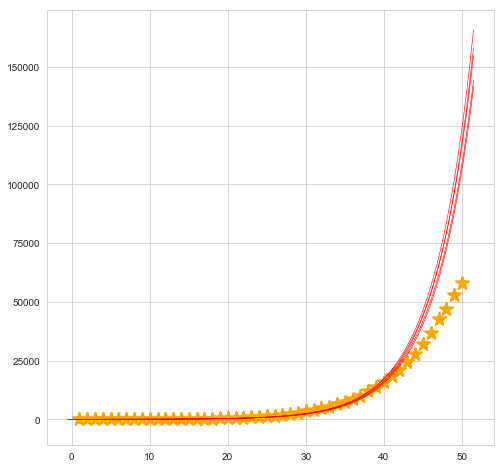

In [426]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for i in range(5):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma)

    ax.scatter(train.day.values, train.total_cases.values, marker='*', s=200, color='orange')
        
    ax.plot(xs, np.expm1(my_w[1]*xs + my_w[0]), color='red', lw=.6)
